In [2]:
###################
# Import Libraries
###################

import pandas as pd # coding but excel
import numpy as np # number stuff, creates arrays
import matplotlib.pyplot as plt # plotting
from scipy.optimize import curve_fit # curve fit class

In [3]:
##############
# Import data
##############

df_10k = pd.read_csv("ImpSpec_Data_10kOhms.csv") # create pandas dataframe
print(df_10k.head()) # print first 5 rows

         V0       VT  Phase  Frequency
0  0.689055  0.01520  -1.50       99.5
1  0.689003  0.01520  -1.50      114.4
2  0.688911  0.01515  -1.70      132.4
3  0.688884  0.01515  -1.90      152.4
4  0.688859  0.01515  -2.05      175.1


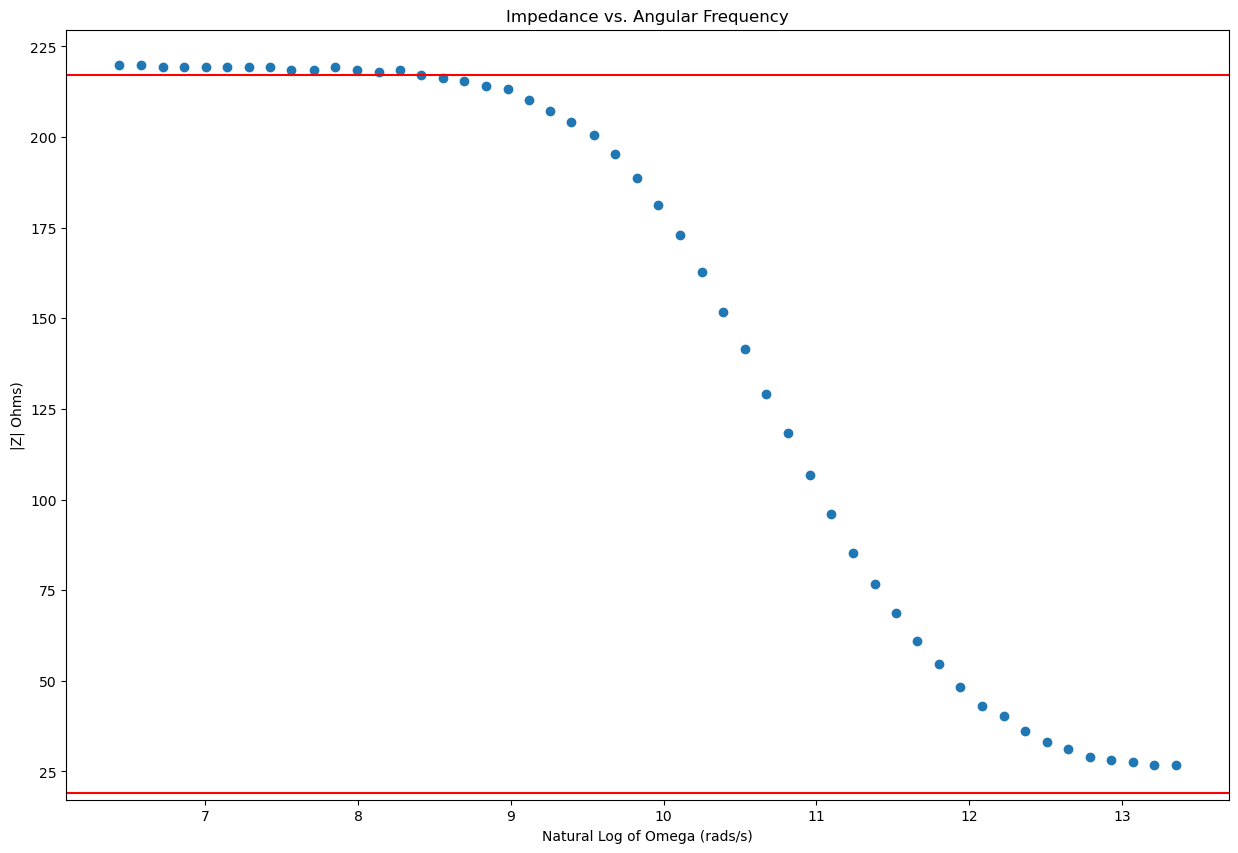

In [48]:
######################
# Setting Up The Math
######################

R_0 = 9970 # Initial resistor value in series with our system under test - 10k as shown from title
R_1 = 217.2 # First resistor value in parrallel with R_2 and capacitor
R_2 = 20.8 # First resistor value in series with capacitor
V_sut = np.array(df_10k["VT"]) # Voltage of "system under test" which is the circuit being evaluated
I_sut = np.array(df_10k["V0"]/R_0) # Current of "system under test" which is the circuit being evaluated I = V_source / R_0
Z = np.array(abs(V_sut/I_sut)) # Absolute value of complex impedence (resistance)
w = np.array(df_10k["Frequency"]*(2*np.pi)) # Angular frequency of our dataset
R_T_parallel = ((R_1**-1) + (R_2**-1))**-1 # Total resistance of parallel circuit when capacitor is 0


############
# Plot data
############

plt.figure(figsize=(15,10))
plt.xlabel("Natural Log of Omega (rads/s)")
plt.ylabel("|Z| (Ohms)")
plt.title("Impedance vs. Angular Frequency")
plt.scatter(np.log(w), Z)
plt.axhline(R_1, c='r')
plt.axhline(R_T_parallel, c='r')
plt.show()

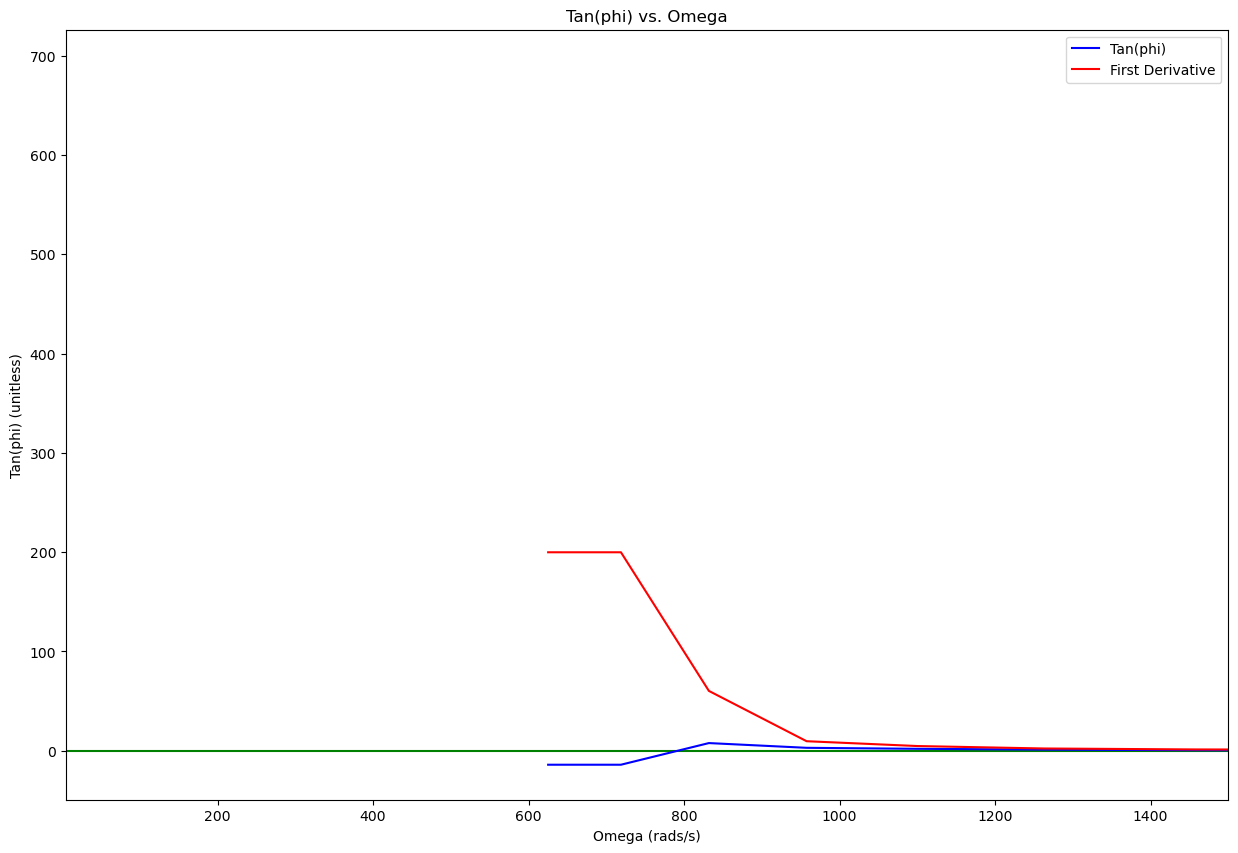

No critical point found.


In [70]:
import numpy as np
import matplotlib.pyplot as plt

phi = np.array(df_10k["Phase"])  # Phase angle from the system under test
tan_phi = np.tan(phi)
dtan_phi_dphi = 1 / (np.cos(phi) ** 2)  # First derivative

# Find zero crossings of the first derivative
zero_crossings = np.where(np.diff(np.sign(dtan_phi_dphi)))[0]

# Get the first critical point
if len(zero_crossings) > 0:
    first_critical_index = zero_crossings[0]
    phi_first_critical = phi[first_critical_index]
else:
    phi_first_critical = None


############
# Plot data
############

plt.figure(figsize=(15, 10))
plt.xlabel("Omega (rads/s)")
plt.ylabel("Tan(phi) (unitless)")
plt.title("Tan(phi) vs. Omega")
plt.xlim(left=5)
plt.xlim(right=1500)
plt.axhline(y=0, c='g')

plt.plot(w, tan_phi, c='b', label="Tan(phi)")
plt.plot(w, dtan_phi_dphi, c='r', label="First Derivative")

# Mark the first critical point if it exists
if phi_first_critical is not None:
    plt.scatter(w[first_critical_index], tan_phi[first_critical_index], c='black', marker='o', label="First Critical Point")

plt.legend()
plt.show()

# Print the first critical point
if phi_first_critical is not None:
    print("First critical point (phi value):", phi_first_critical)
else:
    print("No critical point found.")

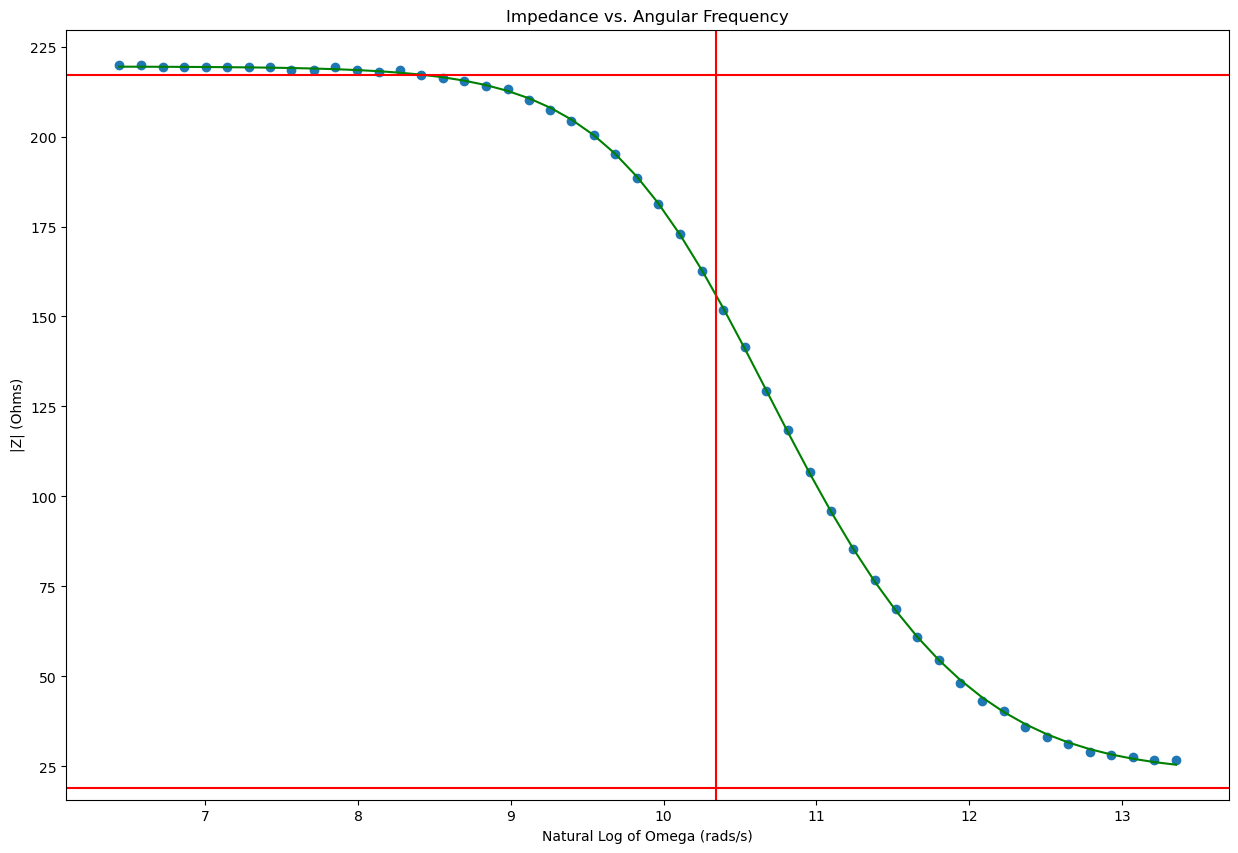

Fit Critical Angular Frequency (ln):  10.34209137332393 
 Fit R_1  219.44820109284584 
 Fit R_2:  25.822674988027625

 Uncertainty matrix (uncertainties lie along diagonal) squared: 
 [[ 4.91449427e+03 -3.82499782e+00 -7.37136233e+00]
 [-3.82499782e+00  1.21203371e-02  2.66441661e-03]
 [-7.37136233e+00  2.66441661e-03  7.42016823e-02]]


In [79]:
################
# Fit The Curve
################

def fit(w, w_c, R_1, R_2):
    Z_mag = R_1/(1+((w/w_c)**2)) * np.sqrt((1 + ((w/w_c)**2 * (1/(1+(R_1/R_2)))))**2 + ((w/w_c)**2 * ((R_1/R_2) / (1+(R_1/R_2)))**2))
    return Z_mag

popt, pcov = curve_fit(fit, w, Z, p0=[w_c:=100, R_1, R_2])
y_fit = fit(w, *popt)

w_c = np.log(popt[0])


############
# Plot data
############

plt.figure(figsize=(15,10))
plt.xlabel("Natural Log of Omega (rads/s)")
plt.ylabel("|Z| (Ohms)")
plt.title("Impedance vs. Angular Frequency")
plt.scatter(np.log(w), Z)
plt.plot(np.log(w), y_fit, c='g') # Fit function
plt.axhline(R_1, c='r')
plt.axhline(R_T_parallel, c='r')
plt.axvline(w_c, c='r')
plt.show()


#####################
# Print fit data
# Print uncertainty
#####################
print("Fit Critical Angular Frequency (ln): ", w_c,
      "\n Fit R_1 ", popt[1],
      "\n Fit R_2: ", popt[2])

print("\n Uncertainty matrix (uncertainties lie along diagonal) squared: \n", pcov)